In [1]:
import pandas as pd
import numpy as np
# Matplot
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer

#from keras.preprocessing.sequence import pad_sequences
from keras_preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
import gensim
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

In [4]:
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [5]:
df = pd.read_csv('dataset.csv', encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [6]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [7]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [8]:
from sklearn.utils import shuffle
df = shuffle(df)

In [9]:
df = df[0:100000]

In [10]:
df.head()

,target,ids,date,flag,user,text
602374,0,2221380706,Thu Jun 18 05:16:24 PDT 2009,NO_QUERY,metalux,@kleinjinx ahhh I've to wait ... and btw. hav...
61586,0,1686775319,Sun May 03 06:43:41 PDT 2009,NO_QUERY,nuttychris,@AyeUpLaura lmfao aww thats unlucky well u be...
969740,4,1827977289,Sun May 17 11:50:21 PDT 2009,NO_QUERY,atworldksch,back home from girlfriend. finishing project d...
610344,0,2224101355,Thu Jun 18 09:05:22 PDT 2009,NO_QUERY,ohhsokay,@Labanya_x3 aw that sucks
1465181,4,2064325353,Sun Jun 07 05:56:53 PDT 2009,NO_QUERY,lndwhite,@anafcardoso thanks


In [11]:
df.shape

(100000, 6)

In [12]:
df[df['target']=='NEGATIVE'].count()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

In [13]:
df[df['target']=='POSITIVE'].count()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

In [14]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [15]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: total: 78.1 ms
Wall time: 97 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

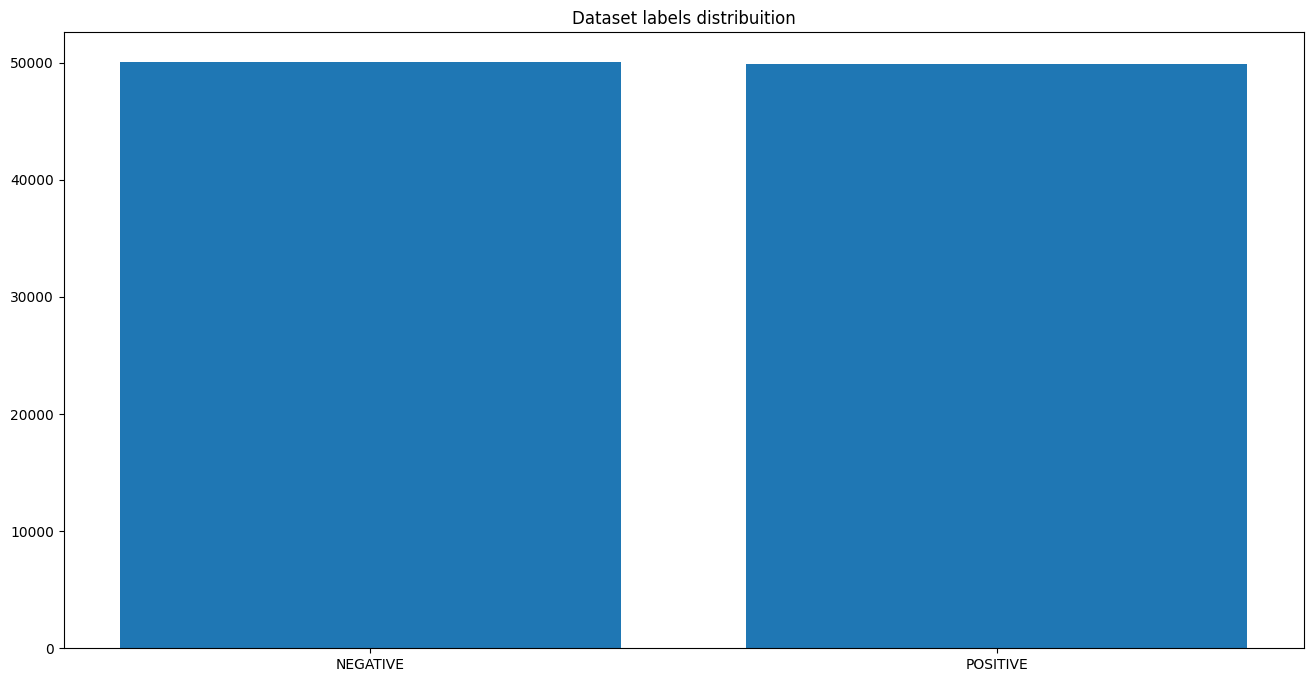

In [16]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [17]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [18]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [19]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: total: 8.28 s
Wall time: 8.49 s


In [20]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 80000
TEST size: 20000


In [21]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: total: 359 ms
Wall time: 357 ms


In [22]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [23]:
w2v_model.build_vocab(documents)

In [24]:
words = list(w2v_model.wv.key_to_index.keys())
vocab_size = len(words)
print("Vocab size:", vocab_size)

Vocab size: 5484


In [25]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: total: 1min 32s
Wall time: 22.8 s


(14581214, 18519264)

In [26]:
similar_words = w2v_model.wv.most_similar("peace")
print(similar_words)

[('tweeties', 0.4900788962841034), ('twitterers', 0.4630887508392334), ('goodmorning', 0.42308688163757324), ('goodnight', 0.4228363633155823), ('tweeps', 0.40787413716316223), ('twitterville', 0.39918044209480286), ('fellow', 0.39880484342575073), ('sweetie', 0.3929828405380249), ('soul', 0.3881964385509491), ('every1', 0.38671374320983887)]


In [27]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 50610
CPU times: total: 2.78 s
Wall time: 2.81 s


In [28]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: total: 3.75 s
Wall time: 3.78 s


In [29]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [30]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (80000, 1)
y_test (20000, 1)


In [31]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (80000, 300)
y_train (80000, 1)

x_test (20000, 300)
y_test (20000, 1)


In [32]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(50610, 300)


In [33]:
import tensorflow as tf
print(tf.__version__)

2.10.0


In [34]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [35]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          15183000  
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 15,343,501
Trainable params: 160,501
Non-trainable params: 15,183,000
_________________________________________________________________


In [36]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [37]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [38]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=2048,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
36/36 [==============================] - 1911s 54s/step - loss: 0.6039 - accuracy: 0.6684 - val_loss: 0.5298 - val_accuracy: 0.7409 - lr: 0.0010
Epoch 2/8
36/36 [==============================] - 7047s 200s/step - loss: 0.5549 - accuracy: 0.7161 - val_loss: 0.5181 - val_accuracy: 0.7449 - lr: 0.0010
Epoch 3/8
36/36 [==============================] - 1039s 29s/step - loss: 0.5447 - accuracy: 0.7217 - val_loss: 0.5132 - val_accuracy: 0.7484 - lr: 0.0010
Epoch 4/8
36/36 [==============================] - 1080s 30s/step - loss: 0.5360 - accuracy: 0.7281 - val_loss: 0.5070 - val_accuracy: 0.7514 - lr: 0.0010
Epoch 5/8
36/36 [==============================] - 1487s 42s/step - loss: 0.5293 - accuracy: 0.7334 - val_loss: 0.5071 - val_accuracy: 0.7499 - lr: 0.0010
Epoch 6/8
36/36 [==============================] - 2462s 68s/step - loss: 0.5234 - accuracy: 0.7358 - val_loss: 0.5028 - val_accuracy: 0.7558 - lr: 0.0010
Epoch 7/8
36/36 [==============================] - 2223s 61s/step - l

In [39]:
%%time
score = model.evaluate(x_test, y_test, batch_size=2048)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

10/10 [==============================] - 29s 3s/step - loss: 0.5062 - accuracy: 0.7509

ACCURACY: 0.7508500218391418
LOSS: 0.5061540007591248
CPU times: total: 2min 31s
Wall time: 28.8 s


In [41]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

KeyError: 'acc'

In [42]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [43]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [44]:
predict("I love the music")

1/1 [==============================] - 0s 404ms/step


C:\Users\mnira\AppData\Local\Temp\ipykernel_8048\1332943948.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return {"label": label, "score": float(score),


{'label': 'POSITIVE',
 'score': 0.9419068694114685,
 'elapsed_time': 0.4647865295410156}

In [45]:
predict("i don't know what i'm doing")

1/1 [==============================] - 0s 78ms/step


C:\Users\mnira\AppData\Local\Temp\ipykernel_8048\1332943948.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return {"label": label, "score": float(score),


{'label': 'NEUTRAL',
 'score': 0.5732876062393188,
 'elapsed_time': 0.12413263320922852}

In [46]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

3/3 [==============================] - 19s 5s/step
CPU times: total: 3min 1s
Wall time: 18.8 s


In [47]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

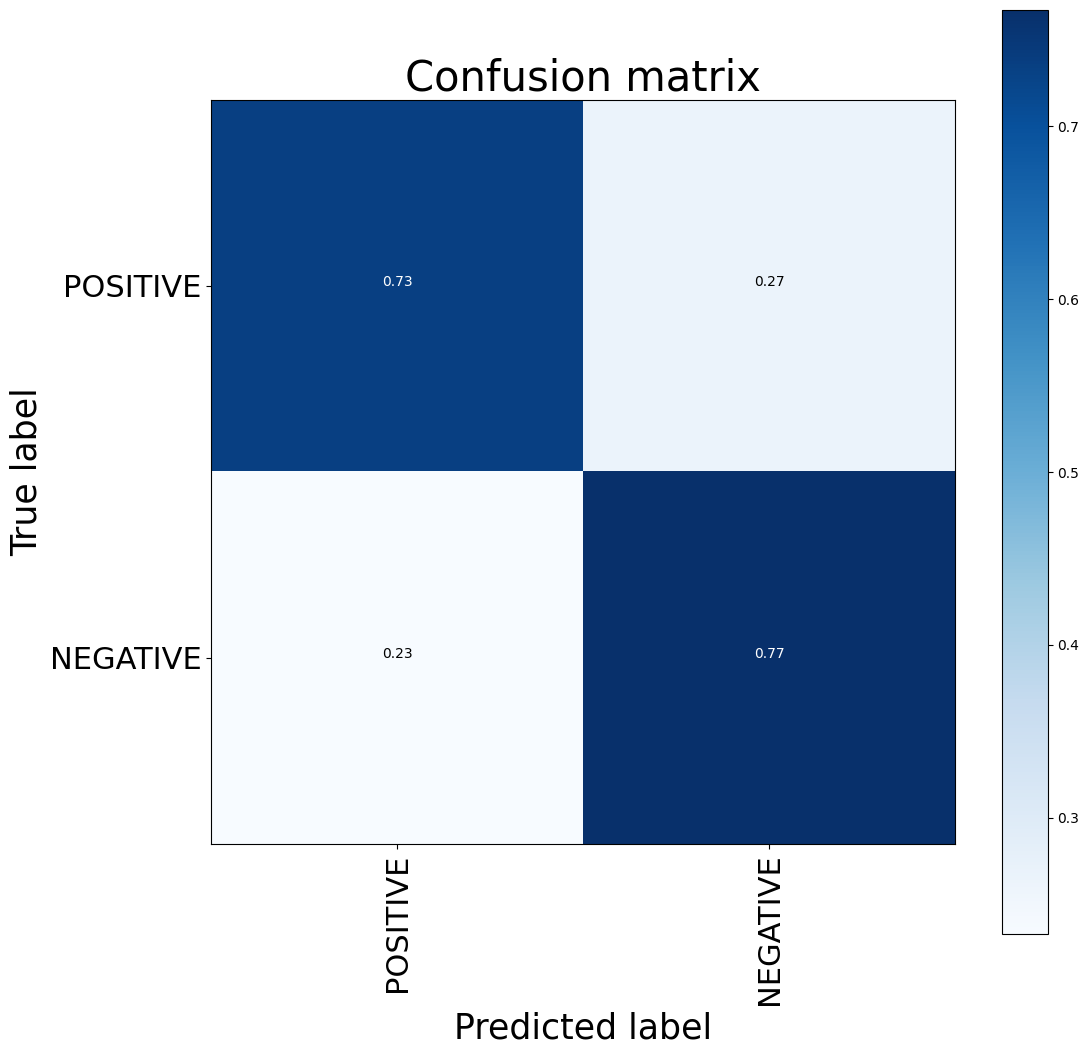

CPU times: total: 344 ms
Wall time: 371 ms


In [48]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

In [49]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.76      0.73      0.75     10027
    POSITIVE       0.74      0.77      0.75      9973

    accuracy                           0.75     20000
   macro avg       0.75      0.75      0.75     20000
weighted avg       0.75      0.75      0.75     20000



In [50]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

In [51]:
accuracy_score(y_test_1d, y_pred_1d)

0.75085